In [ ]:
import numpy as np
import pandas as pd
import json
import codecs
import datetime
import sys

In [ ]:
sys.path.append('.')

In [ ]:
import vector_creator.score_vectors_assembly as svec
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,9), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [ ]:
path = '/Users/smuel/AndroidStudioProjects/LuckyMeIntgratedSDK/metadata_init_phase/'

In [ ]:
lst = svec.file_list_with_unique_id(path, [])

In [ ]:
lst
uid = lst.get('unique_ids')[0]
meta_files = lst.get('file_list')

In [ ]:
uid

CONVERT JSON METADATA BY UNIQUE_UID TO:  
1. Dict. OF DataFrames BY KEY FIELD {CallLogs, ImgMetaData, InstallApps} 
2. CONFIGURATION OF SAMPLING RATED AND LIFE CYCLE 
3. TUPLE OF GPS (LAT, LONG) IF EXISTS

In [ ]:
config_dict, loc_dict, df_dict = svec.df_for_init_meta(uid, path, lst['file_list'])

In [ ]:
config_dict

In [ ]:
df_dict.keys()

EXTRACT BY UNIQUE_UID: 
1. Extract call-logs DataFrame qiven by unique_uid
2. '05fa68e5-0ba3-4783-9c07-42740c4914c6_CallLogs' is Dict key in the format : UNIQUE-ID_FEILD-TYPE
3. the Dict Value for this key is the corresponding data frame 

In [ ]:
df2 = df_dict['05fa68e5-0ba3-4783-9c07-42740c4914c6_ImgMetaData']

In [ ]:
df2.head(10)

In [ ]:
df = df_dict['05fa68e5-0ba3-4783-9c07-42740c4914c6_CallLogs']

In [ ]:
df.head(10)

In [ ]:
lat = loc_dict[0]['Latitude']
long = loc_dict[0]['Longitude']

In [ ]:
(lat, long)

In [ ]:
vec1 = svec.create_call_logs_vector_for_unique_id(uid, df, (lat, long))

In [ ]:
vec1.tail(15)

In [ ]:
vec2 = svec.create_photo_gallery_vector_for_unique_id(uid, df2, (lat, long))

In [ ]:
vec2.head(10)

In [ ]:
vec = vec1.append(vec2)

In [ ]:
vec.size

In [ ]:
vec.name

***
# <font color=blackcursor>Working with the Autonomous Database (ADB)</font>


***

## Business Uses:

The Accelerate Data Science (ADS) SDK can load data from various resources and in a wide range of formats, the ADB is one of the most frequently used resources.
 - A business may have an existing dataset that they have stored in ADW/ATP and they want to load and explore with the notebook.
 
 ---
 

<a id='setup'></a>
 Setting up your notebook session to access ADB

### 2. Select the database

Select the database that you want to connect to. If you do not have one, create one. 

In [ ]:
import os
# Enter connection information and wallet file directory

database_name = "DBlouie7"
wallet_storage_directory = os.path.join(os.path.expanduser("~"),"ADB")

In [ ]:
import ads
import configparser
import re
import shutil
from tempfile import NamedTemporaryFile
from zipfile import ZipFile

ads.set_documentation_mode(False)

# Create the wallet directory if missing: 
#os.makedirs(wallet_storage_directory, mode=0o700, exist_ok=True)

wallet_path = os.path.join(wallet_storage_directory, database_name)

# Prepare to store ADB connection information
adb_config = os.path.join(wallet_storage_directory, '.credentials')

# Write a configuration file for login creds.
config = configparser.ConfigParser()
config.read(adb_config)


Below is a sample code on how to read in the credentials configuration file and access the contents for each database

### 11. To test the connection to the ADB.

The easiest way to test the ADB connection is to run the `sqlplus` CLI tool. The `TNS_ADMIN` variable needs to be set and then the connection string is used to connect. This connection string is of the format `\<user_name>/\<password>@\<SID>`. This information can be obtained from the credentials file.

Once this is working, the notebook will demonstrate other methods to connect that are more practical for use within notebooks.

In [ ]:
# Add TNS_ADMIN to the environment
os.environ['TNS_ADMIN'] = config[database_name].get('tns_admin')

# Test the database connection
creds = config[database_name]
connect = 'sqlplus ' + creds.get('user') + '/' + creds.get('password') + '@' + creds.get('sid')
print(os.popen(connect).read())

You should see something similar like below if the connection is successful.

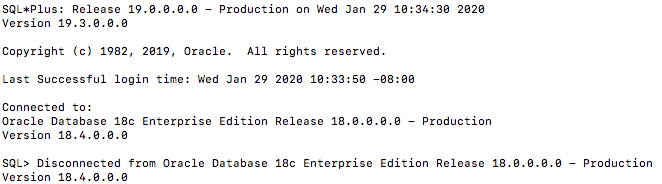

If the output above is similar, then you have a connection to the database.

<a id='load'></a>
# 2. Load an ADB table as an `ADSDataset` object

Now that you have successfully set up a connection to ADB, we can start querying the database. In principle, you only have to go through the setup process once. Before querying the database, you will have to load the credentials file content to memeyr 

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
import logging
import os

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)

from ads.dataset.factory import DatasetFactory

To work with ADS, it is best to create a connection string to the database. This is passed to `DatasetFactory.open()` method to make the connection. Again, the credentials configuration file will be use to build the string.

In [ ]:
# Add TNS_ADMIN to the environment
creds = config[database_name]
os.environ['TNS_ADMIN'] = config[database_name].get('tns_admin')

# Get the URI to connect to the database
uri='oracle+cx_oracle://' + creds.get('user') + ':' + creds.get('password') + '@' + creds.get('sid')
print(uri)

The next step will be to test the connection by pulling a table and load that table as an `ADSDataset` object through `DatasetFactory`. 

By default, the ADB comes with the table `sales` in the `SH` schema. If that table has been removed, you will need to update the code to provide the valid name of a table in a schema that you have access to.

ADS supports the ability to query based on an arbitrary SQL expression. In the example above the `table` parameter contained the schema and table that was to be accessed. This parameter also takes an SQL expression.

Below, the database will return the total sales by customer in descending order.

In [ ]:
sql_total_sale = """
    SELECT CUST_ID, SUM(AMOUNT_SOLD) AS TOTAL_SALES 
    FROM SH.SALES 
    GROUP BY CUST_ID 
    ORDER BY SUM(AMOUNT_SOLD) DESC
    """

In [ ]:
total_sale = DatasetFactory.open(uri, format="sql", table=sql_total_sale)

In [ ]:
total_sale.head()

In [ ]:
total_sale.show_in_notebook()

<a id='run'></a>
# 3. Run an SQL query on ADB using SQLAlchemy and Pandas

`SQLAlchemy` is compatible with ADB. Below an `SQLAlchemy` `Engine` object is used to connect to the URI for the database (see above). The `Pandas` `read_sql` method is used to run an arbitrary SQL statement.

In [ ]:
from sqlalchemy import create_engine

# Add TNS_ADMIN to the environment
creds = config[database_name]
os.environ['TNS_ADMIN'] = config[database_name].get('tns_admin')

# Make a connection to the Engine and run a query
engine = create_engine(uri)
sql_customers = "SELECT * FROM SH.CUSTOMERS"
customers = pd.read_sql(sql_customers, con=engine)
customers.head()

`read_sql` is a convience method around `read_sql_query` and `read_sql_table`. Both of these methods are supported. Let us count the products in each category.

In [ ]:
sql_category = """
    SELECT PROD_CATEGORY, COUNT(*) AS N 
    FROM SH.PRODUCTS 
    GROUP BY PROD_CATEGORY 
    ORDER BY COUNT(*) DESC
    """
category = pd.read_sql_query(sql_category, con=engine)
category.head()

In [ ]:
sql_channels = """
   select * from channels
    """
channels = pd.read_sql_query(sql_channels, con=engine)
channels.head()

In [ ]:
channels.to_sql('channels3', con=engine, if_exists='append', index=False, chunksize=2000)


Now, call the `read_sql_table` method on the products table.

In [ ]:
products = pd.read_sql_table(table_name='products', con=engine, schema='SH')
products.head()

<a id='create'></a>
# 4. Creating a table with `SQLAlchemy` and `Pandas` and updating it

The generic methods above all arbitrary SQL command to be run to perform DML (Data Manipulation Language) commands to alter the data. However, a common use pattern for the data scientist is to pull data from a table, perform manipulations on it and then push that data frame back into the database. This pattern will be demonstrated. This section will create a table called `PRODUCT_DEMO`, if this table exists in the default schema, please change the name in the code as it will be clobbered. The database user will need permissions to create and update a table.

Let us make a copy of the `PRODUCTS` table from the `SH` schema. Then create the table `PRODUCT_DEMO` in the default schema.

In [ ]:
products_demo = products.copy()
products_demo.to_sql(name='products_demo', index=False, con=engine, if_exists='replace')
products_demo.head()

Let us take a look at `PROD_ID = 116` in the `products_demo` data frame. The product name and description suggests that it a pack of 5.

In [ ]:
products_demo.loc[products_demo.prod_id==116]

When the database is queried, it does not reflect the change. That is because we have to push the table back to the database.

In [ ]:
pd.read_sql_query('SELECT * FROM products_demo WHERE prod_id = 116', con=engine)

Using the `to_sql` method the entire data frame will be pushed back to the database and replace the existing `products_demo` table. In this example, only a single record was changed. However, it is meant to illustrate that changes to a data frame can be pushed back, en mass, to the database. This would include any updates to the data and structure of the data frame.

In [ ]:
products_demo.to_sql(name='products_demo', index=False, con=engine, if_exists='replace')

In [ ]:
products_demo.to_sql(name='products_demo', index=False, con=engine, if_exists='replace')
pd.read_sql_query('SELECT * FROM products_demo WHERE prod_id = 116', con=engine)